# QC slide image against block image

### Import the necessary libraries

In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import measure


### Read processed images

In [2]:
# Read all images
import os

slides = []
blocks = []

path = './img/Slides_processed/'
files = os.listdir(path)
for index, file in enumerate(files):
    # convert image from BGR to RGB
    img_sld = cv2.cvtColor(cv2.imread(os.path.join(path, file)), cv2.COLOR_BGR2RGB)
    slides.append(img_sld)

path = './img/Blocks_processed/'
files = os.listdir(path)
for index, file in enumerate(files):
    # convert image from BGR to RGB
    img_blk = cv2.cvtColor(cv2.imread(os.path.join(path, file)), cv2.COLOR_BGR2RGB)
    blocks.append(img_blk)

In [3]:
def show1img(img, img_title):
    figure_size = 10
    plt.figure(figsize=(figure_size, figure_size))
    plt.imshow(img)
    plt.title(img_title)

    plt.show()


def show2img(img1, img1_title, img2, img2_title):
    figure_size = 20
    plt.figure(figsize=(figure_size, figure_size))
    plt.subplot(1, 2, 1), plt.imshow(img1)
    plt.title(img1_title), plt.xticks([]), plt.yticks([])
    plt.subplot(1, 2, 2), plt.imshow(img2)
    plt.title(img2_title), plt.xticks([]), plt.yticks([])

    plt.show()


def crop(image, x1, x2, y1, y2):
    height = image.shape[0]
    width = image.shape[1]
    cropped = image[y1:y2, x1:x2]
    return cropped.copy()

def FlipImg(img, direction):
    return cv2.flip(img, direction).copy()

In [4]:
def resize_with_pad(image, height=1500, width=1500):

    def get_padding_size(image):
        h, w, _ = image.shape
        longest_edge = max(h, w)
        top, bottom, left, right = (0, 0, 0, 0)
        if h < longest_edge:
            dh = longest_edge - h
            top = dh // 2
            bottom = dh - top
        elif w < longest_edge:
            dw = longest_edge - w
            left = dw // 2
            right = dw - left
        else:
            pass
        return top, bottom, left, right

    top, bottom, left, right = get_padding_size(image)
    BLACK = [0, 0, 0]
    constant = cv2.copyMakeBorder(image, top , bottom, left, right, cv2.BORDER_CONSTANT, value=BLACK)

    resized_image = cv2.resize(constant, (height, width))

    return resized_image



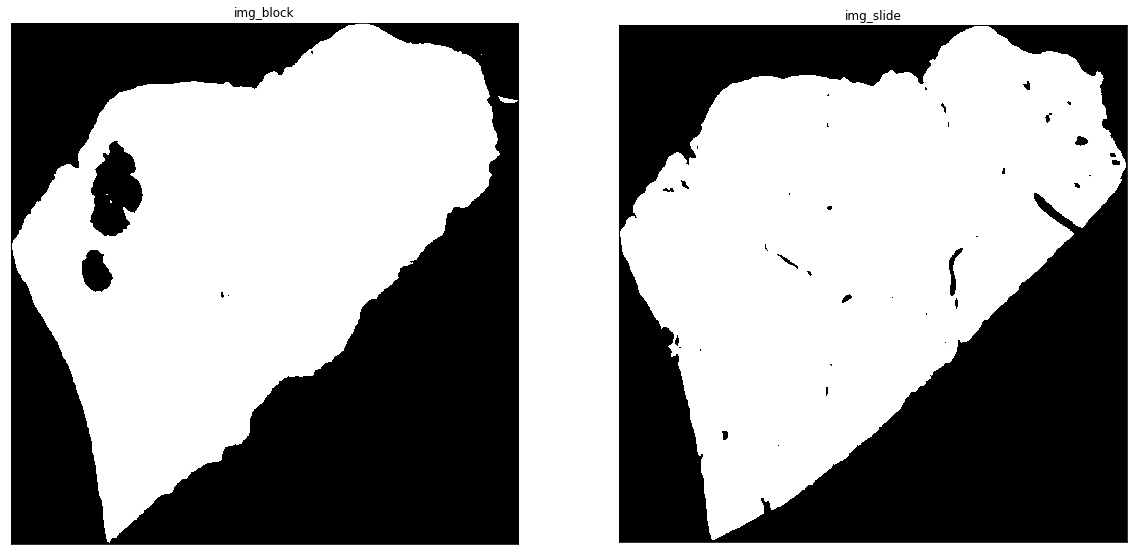

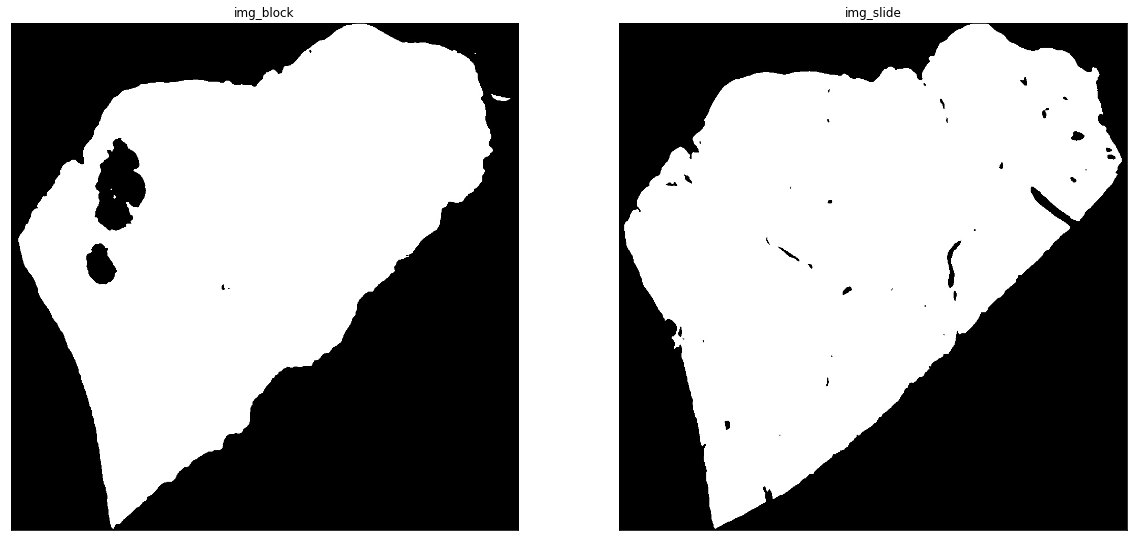

In [12]:
### Select the sample pair that we are going to work with
sample_index = 9
img_block = blocks[sample_index].copy()
img_slide = slides[sample_index].copy()



### QC function
* The functions take in the preprocessed block-slide image pair, and return a series of scores that represent the "quality" of the slide image against the block image.
* Possible scoring methods:
    1. MSE
    2. Structure Similarity (SSIM)
    3. Boundaries
    4. Section completeness
    5. etc.

In [45]:
def SIFT(img_block, img_slide):
    # Check for similarities between the 2 images
    sift = cv2.xfeatures2d.SIFT_create()
    kp_1, desc_1 = sift.detectAndCompute(img_slide, None)
    kp_2, desc_2 = sift.detectAndCompute(img_block, None)

    index_params = dict(algorithm=0, trees=5)
    search_params = dict()
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(desc_1, desc_2, k=2)

    good_points = []
    for m, n in matches:
        if m.distance < 0.7*n.distance:
            good_points.append(m)

    # Define how similar they are
    number_keypoints = 0
    if len(kp_1) <= len(kp_2):
        number_keypoints = len(kp_1)
    else:
        number_keypoints = len(kp_2)
    
    print('=========== SIFT ===========')
    print("Keypoints 1ST Image: " + str(len(kp_1)))
    print("Keypoints 2ND Image: " + str(len(kp_2)))
    print("GOOD Matches:", len(good_points))
    print("How good it's the match: ", len(good_points) / number_keypoints)

    result = cv2.drawMatches(img_slide, kp_1, img_block, kp_2, good_points, None)

    show1img(result, 'result')
    
    return len(good_points) / number_keypoints

In [52]:
def CompareHist(img_block, img_slide):
    # images: it is the source image of type uint8 or float32. it should be given in square brackets, ie, "[img]".
    # channels: it is also given in square brackets. It is the index of channel for which we calculate histogram. For example, if input is grayscale image, its value is [0]. For color image, you can pass [0], [1] or [2] to calculate histogram of blue, green or red channel respectively.
    # mask: mask image. To find histogram of full image, it is given as "None". But if you want to find histogram of particular region of image, you have to create a mask image for that and give it as mask. (I will show an example later.)
    # histSize: this represents our BIN count. Need to be given in square brackets. For full scale, we pass [256].
    # ranges: this is our RANGE. Normally, it is [0, 256].
    
    # Use the 0-th and 1-st channels
    channels = [0]
    histSize = [256]
    ranges = [0, 256]


    hist_block = cv2.calcHist(images=[img_block],
                              channels=channels,
                              mask=None,
                              histSize=histSize,
                              ranges=ranges)

    cv2.normalize(hist_block, hist_block, alpha=0,
                  beta=1, norm_type=cv2.NORM_MINMAX)

    hist_slide = cv2.calcHist(images=[img_slide],
                              channels=channels,
                              mask=None,
                              histSize=histSize,
                              ranges=ranges,
                              accumulate=False)

    cv2.normalize(hist_slide, hist_slide, alpha=0,
                  beta=1, norm_type=cv2.NORM_MINMAX)
    
    methods = {
        0: 'Correlation',
        1: 'Chi-Square',
        2: 'Intersection ',
        3: 'Bhattacharyya distance'
    }
    
    print('=========== Compare Histograms ===========')
    for compare_method in range(4):
        block_block = cv2.compareHist(hist_block, hist_block, compare_method)
        block_slide = cv2.compareHist(hist_block, hist_slide, compare_method)
        
        print('Method:', methods[compare_method])
        print('   block-block match: ', block_block)
        print('   block-slide match:',  block_slide)
        
    score_0 = 

In [35]:
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

def qc(img_block, img_slide):

    IMAGE_W, IMAGE_H = 2000, 2000
    img_block = resize_with_pad(img_block, height=IMAGE_H, width=IMAGE_W)
    img_slide = resize_with_pad(img_slide, height=IMAGE_H, width=IMAGE_W)


    show2img(img_block, 'img_block', img_slide, 'img_slide')
    
    
    img_block = cv2.cvtColor(img_block,cv2.COLOR_RGB2GRAY)
    img_slide = cv2.cvtColor(img_slide,cv2.COLOR_RGB2GRAY)
    # Add your code here

    # compute the mean squared error and structural similarity
    # index for the images
    score_mse = mse(img_block, img_slide)
    score_ssim = measure.compare_ssim(img_block, img_slide)
    
    print('=========== MSE ===========')
    print("MSE: %.2f" % score_mse)
    
    print('=========== SSIM ===========')
    print("SSIM: %.2f" %score_ssim)
    
    SIFT(img_block, img_slide)
    CompareHist(img_block, img_slide)
    
    

### Run the function and display output

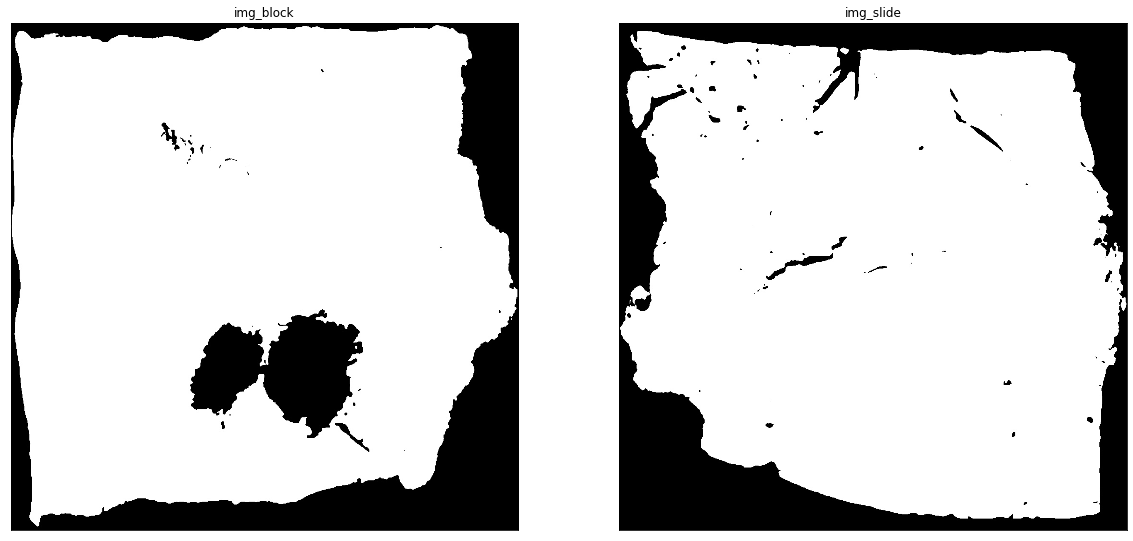

=========== MSE ===========
MSE: 13961.26
=========== SSIM ===========
SSIM: 0.75
=========== SIFT ===========
Keypoints 1ST Image: 2757
Keypoints 2ND Image: 2718
GOOD Matches: 227
How good it's the match:  0.08351729212656366


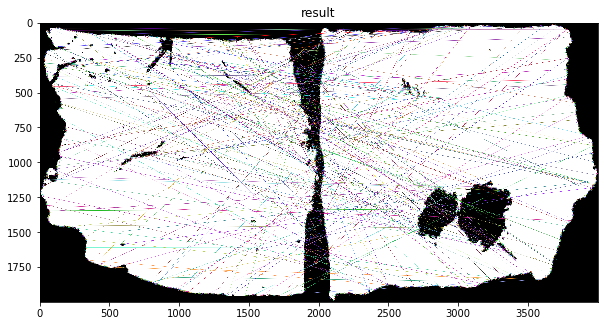

=========== Compare Histograms ===========
Method: Correlation
   block-block match:  1.0
   block-slide match: 0.9999987984695998
Method: Chi-Square
   block-block match:  0.0
   block-slide match: 0.013813322467226104
Method: Intersection 
   block-block match:  1.3248184570111334
   block-slide match: 1.3225176246141928
Method: Bhattacharyya distance
   block-block match:  0.0
   block-slide match: 0.022499796486246778


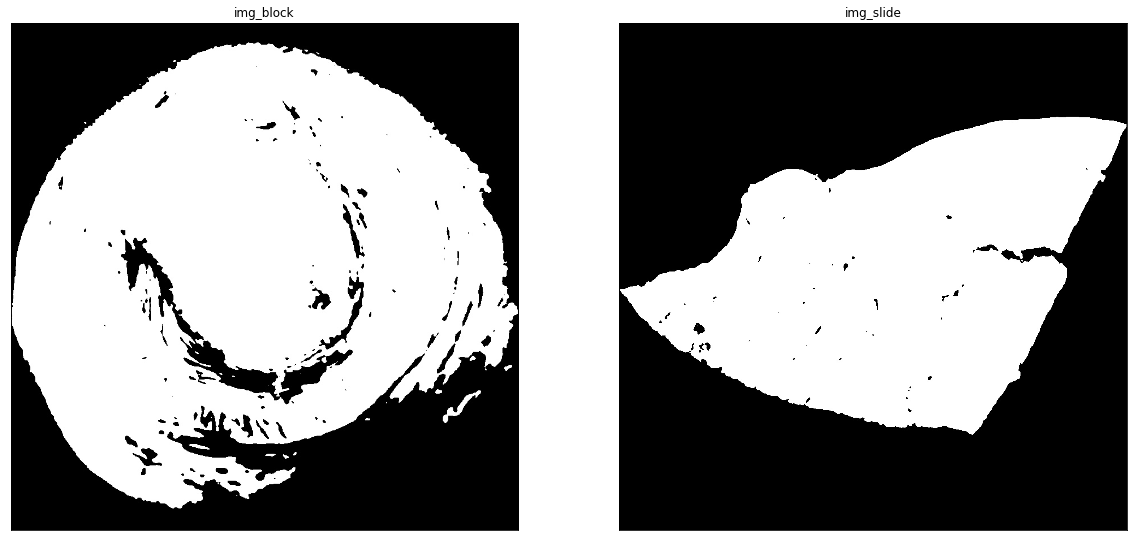

=========== MSE ===========
MSE: 20200.20
=========== SSIM ===========
SSIM: 0.64
=========== SIFT ===========
Keypoints 1ST Image: 1616
Keypoints 2ND Image: 5388
GOOD Matches: 130
How good it's the match:  0.08044554455445545


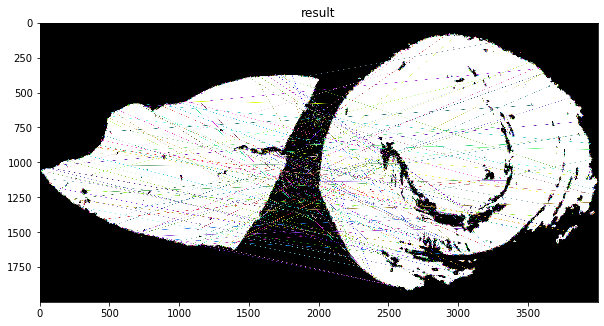

=========== Compare Histograms ===========
Method: Correlation
   block-block match:  1.0
   block-slide match: 0.8941229504820052
Method: Chi-Square
   block-block match:  0.0
   block-slide match: 0.4080438300271798
Method: Intersection 
   block-block match:  1.7963674894490396
   block-slide match: 1.2682179852035915
Method: Bhattacharyya distance
   block-block match:  0.0
   block-slide match: 0.18739583512630767


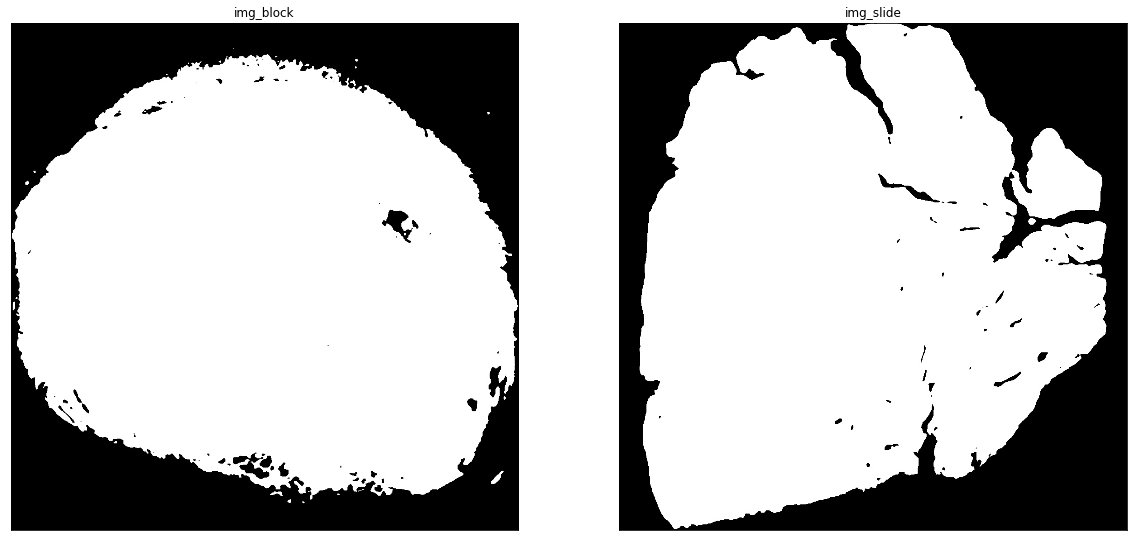

=========== MSE ===========
MSE: 12295.66
=========== SSIM ===========
SSIM: 0.77
=========== SIFT ===========
Keypoints 1ST Image: 2976
Keypoints 2ND Image: 2970
GOOD Matches: 331
How good it's the match:  0.11144781144781145


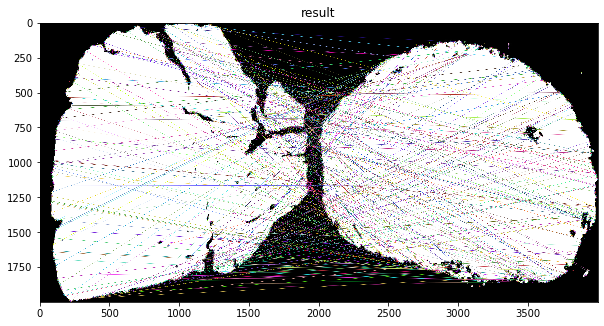

=========== Compare Histograms ===========
Method: Correlation
   block-block match:  1.0
   block-slide match: 0.9998236374746456
Method: Chi-Square
   block-block match:  0.0
   block-slide match: 0.008633822134917115
Method: Intersection 
   block-block match:  1.559915188749983
   block-slide match: 1.5275527438170684
Method: Bhattacharyya distance
   block-block match:  0.0
   block-slide match: 0.02612964670146053


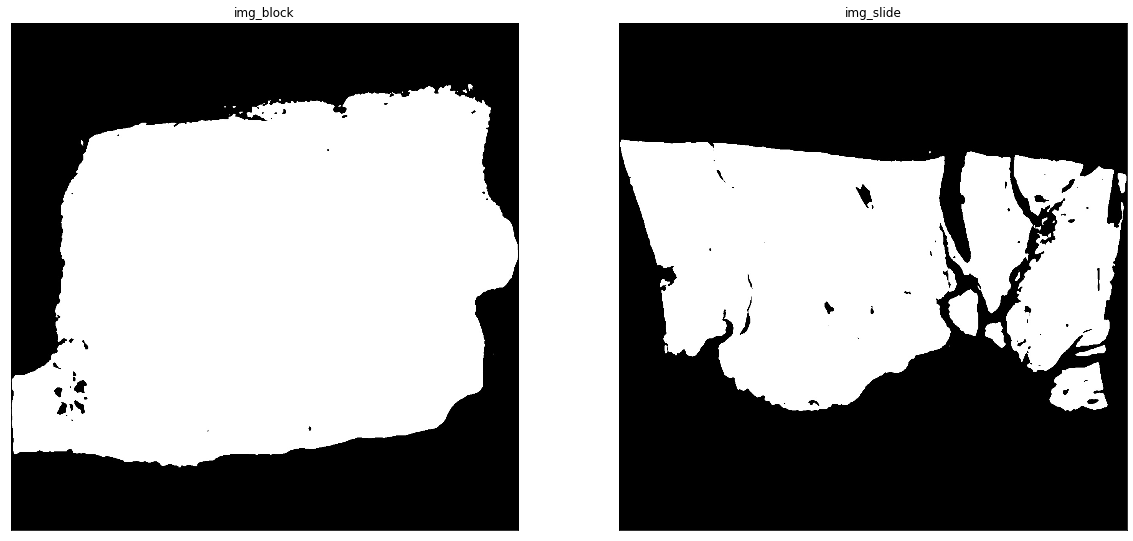

=========== MSE ===========
MSE: 17145.05
=========== SSIM ===========
SSIM: 0.71
=========== SIFT ===========
Keypoints 1ST Image: 3092
Keypoints 2ND Image: 1852
GOOD Matches: 332
How good it's the match:  0.17926565874730022


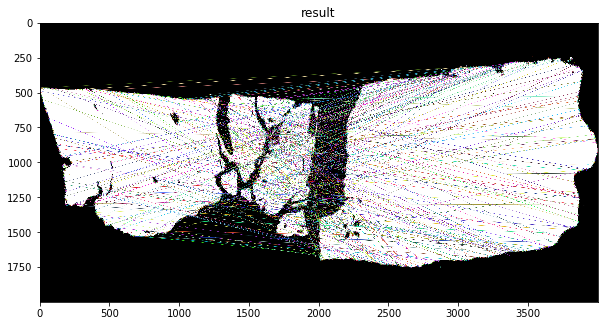

=========== Compare Histograms ===========
Method: Correlation
   block-block match:  1.0
   block-slide match: 0.9140373508821187
Method: Chi-Square
   block-block match:  0.0
   block-slide match: 0.292522864680813
Method: Intersection 
   block-block match:  1.7867778587542489
   block-slide match: 1.3420339285294176
Method: Bhattacharyya distance
   block-block match:  0.0
   block-slide match: 0.15317335192031212


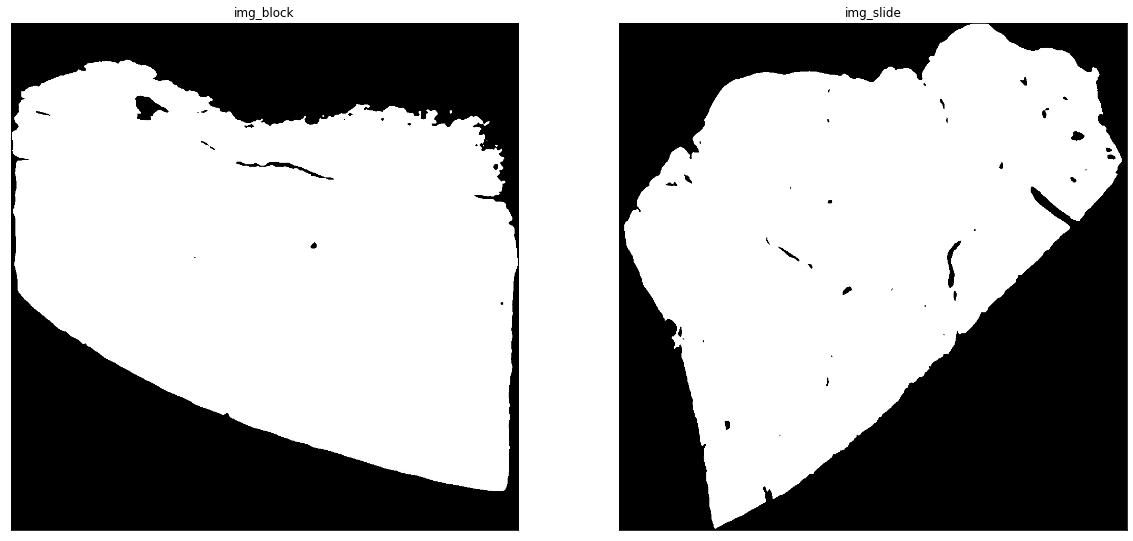

=========== MSE ===========
MSE: 21834.39
=========== SSIM ===========
SSIM: 0.64
=========== SIFT ===========
Keypoints 1ST Image: 2166
Keypoints 2ND Image: 2119
GOOD Matches: 327
How good it's the match:  0.15431807456347332


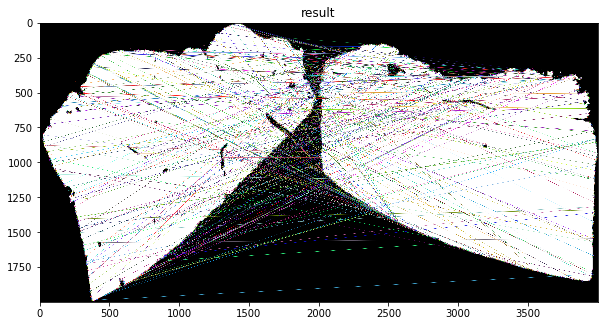

=========== Compare Histograms ===========
Method: Correlation
   block-block match:  1.0
   block-slide match: 0.991891034835714
Method: Chi-Square
   block-block match:  0.0
   block-slide match: 0.0663243606809174
Method: Intersection 
   block-block match:  1.6984307626171358
   block-slide match: 1.6969337201317103
Method: Bhattacharyya distance
   block-block match:  0.0
   block-slide match: 0.04812735475475743


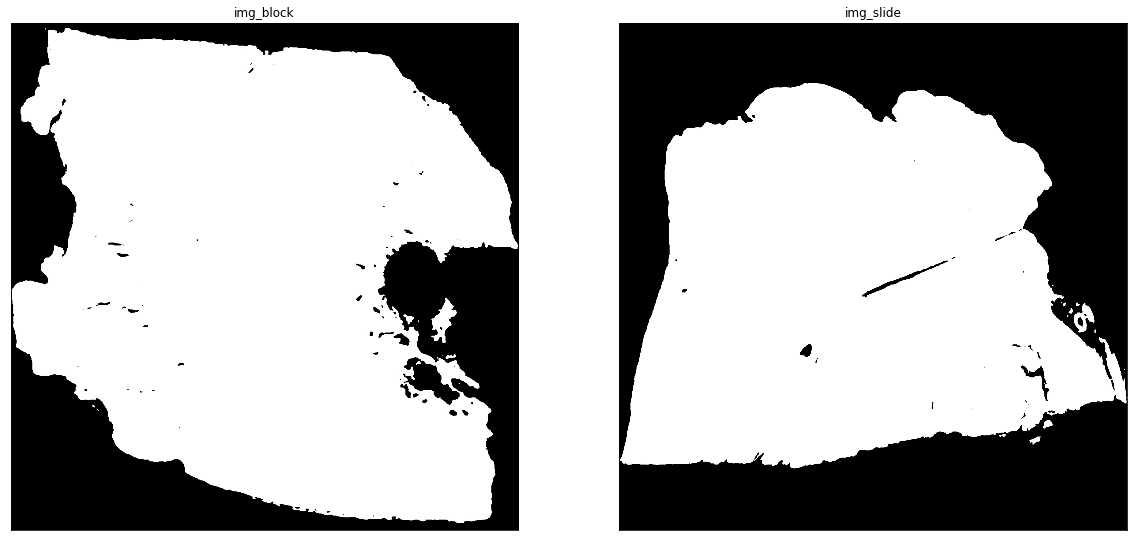

=========== MSE ===========
MSE: 19245.01
=========== SSIM ===========
SSIM: 0.67
=========== SIFT ===========
Keypoints 1ST Image: 2001
Keypoints 2ND Image: 2936
GOOD Matches: 241
How good it's the match:  0.12043978010994502


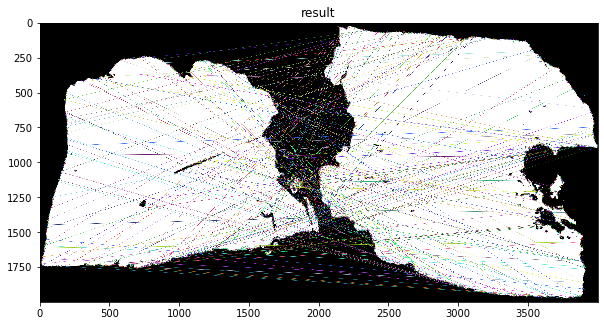

=========== Compare Histograms ===========
Method: Correlation
   block-block match:  1.0
   block-slide match: 0.9545402629505273
Method: Chi-Square
   block-block match:  0.0
   block-slide match: 0.4241753594851295
Method: Intersection 
   block-block match:  1.4803871616895776
   block-slide match: 1.4711785987146868
Method: Bhattacharyya distance
   block-block match:  0.0
   block-slide match: 0.1191094815016396


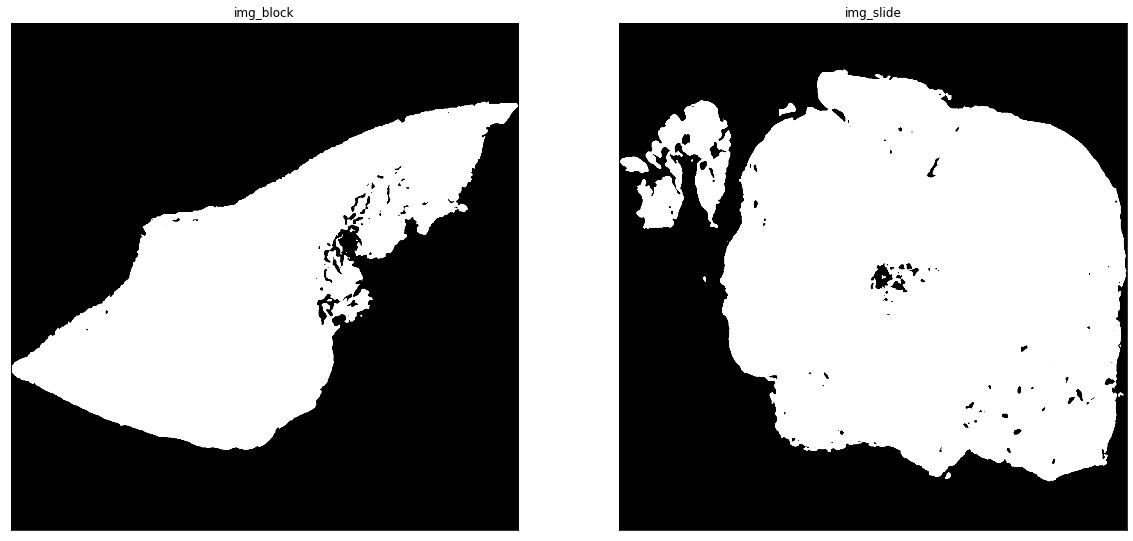

=========== MSE ===========
MSE: 22190.36
=========== SSIM ===========
SSIM: 0.63
=========== SIFT ===========
Keypoints 1ST Image: 2888
Keypoints 2ND Image: 2172
GOOD Matches: 289
How good it's the match:  0.13305709023941067


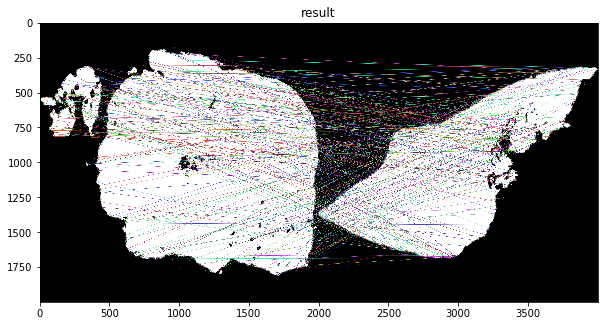

=========== Compare Histograms ===========
Method: Correlation
   block-block match:  1.0
   block-slide match: 0.896035018309953
Method: Chi-Square
   block-block match:  0.0
   block-slide match: 0.9724745502967674
Method: Intersection 
   block-block match:  1.4237200371408107
   block-slide match: 1.3323529478111595
Method: Bhattacharyya distance
   block-block match:  0.0
   block-slide match: 0.17496249601700126


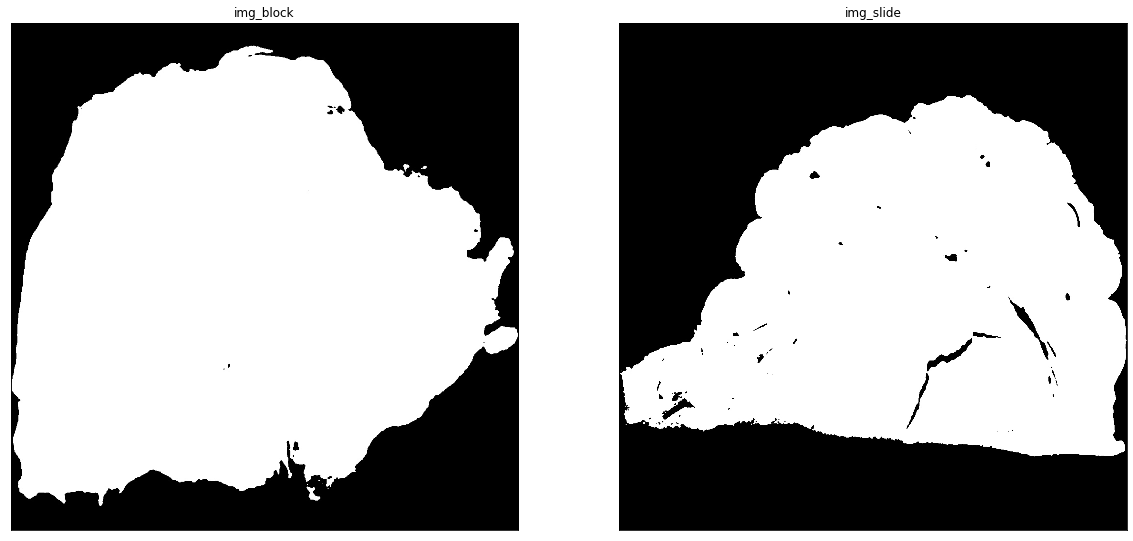

=========== MSE ===========
MSE: 17910.99
=========== SSIM ===========
SSIM: 0.70
=========== SIFT ===========
Keypoints 1ST Image: 2016
Keypoints 2ND Image: 2075
GOOD Matches: 224
How good it's the match:  0.1111111111111111


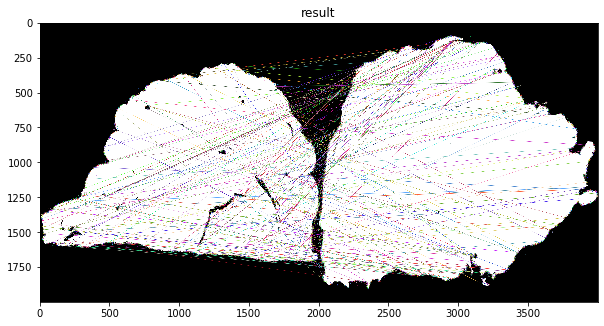

=========== Compare Histograms ===========
Method: Correlation
   block-block match:  1.0
   block-slide match: 0.95149913761432
Method: Chi-Square
   block-block match:  0.0
   block-slide match: 0.33355599801811575
Method: Intersection 
   block-block match:  1.6063125145756203
   block-slide match: 1.514620298281443
Method: Bhattacharyya distance
   block-block match:  1.0536712127723509e-08
   block-slide match: 0.11349818410788928


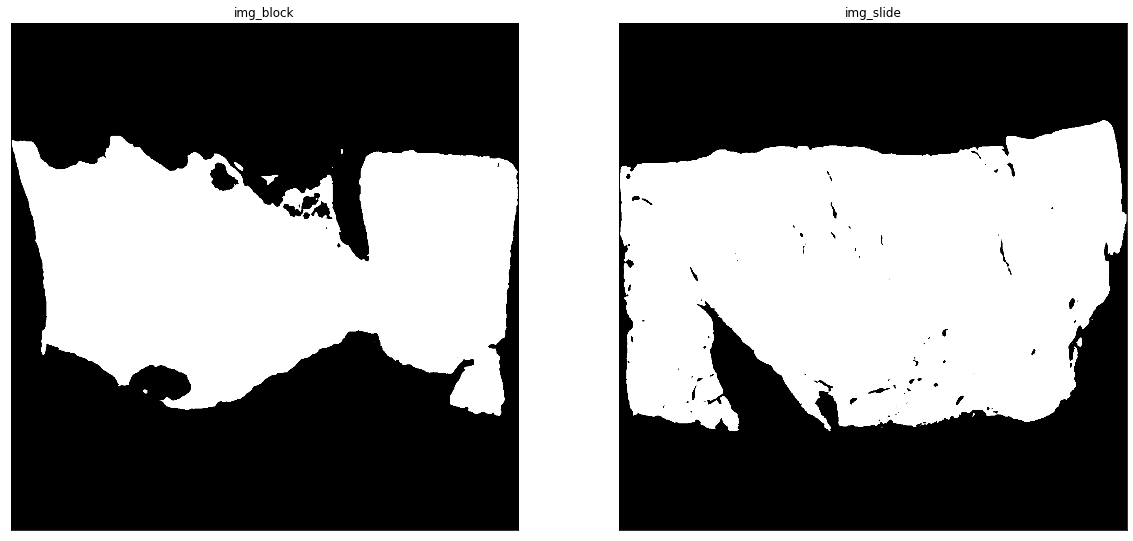

=========== MSE ===========
MSE: 10802.44
=========== SSIM ===========
SSIM: 0.81
=========== SIFT ===========
Keypoints 1ST Image: 2143
Keypoints 2ND Image: 2040
GOOD Matches: 225
How good it's the match:  0.11029411764705882


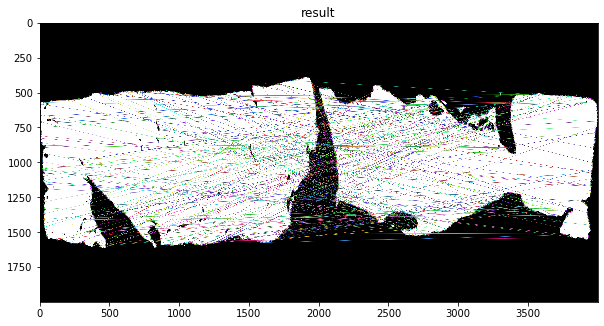

=========== Compare Histograms ===========
Method: Correlation
   block-block match:  1.0
   block-slide match: 0.9790405469805317
Method: Chi-Square
   block-block match:  0.0
   block-slide match: 0.18129480192019642
Method: Intersection 
   block-block match:  1.608939708550679
   block-slide match: 1.6083618149077665
Method: Bhattacharyya distance
   block-block match:  0.0
   block-slide match: 0.07606787401588112


IndexError: list index out of range

In [57]:
for i in range(len(blocks)):
    qc(blocks[i], slides[i+5])